In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from gp_oed_surrogate import create_gp, save_gp, load_gp

In [2]:
def kernel(x_1, x_2, params):
    k_theta = params["const_0"]*(x_1[0]-params["const_1"])*(x_2[0]-params["const_1"]) + params["const_2"]
    k_d = params["const_3"]*jnp.exp(-0.5*((x_1[1] - x_2[1])/params["length"])**2)
    return k_theta + k_d

In [3]:
def load_data(data_dir):
    # Import data from text file:
    training_data = np.loadtxt(data_dir)
    # Note that columns of beam data arranged as: [angle, c10, disp]
    # Rearrange to form: [c10, angle, x, y, z, disp]:
    training_data.T[[0,1]] = training_data.T[[1,0]]
    # Convert to Jax.numpy array:
    rows_2_extract = training_data[:,0] > 1.
    x_train = jnp.array(training_data[rows_2_extract,0:-1])
    y_train = jnp.array(training_data[rows_2_extract,-1])
    return (x_train, y_train)

In [4]:
def plot_gp_surface(d_pts, theta_pts, y_pts, train_dict=None):
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(theta_pts, d_pts, y_pts, cmap='viridis')
    cbar = fig.colorbar(contour_fig)
    ax.set_xlabel('Beam stiffness c10')
    ax.set_ylabel('Angle of Beam in Degrees')
    cbar.set_label('Displacement', rotation=270, labelpad=15)
    if train_dict:
        plt.plot(train_dict['d'], train_dict['theta'], 'x', color='red', markersize=10)
    fig.patch.set_facecolor('white')
    plt.show()

In [5]:
# Load training data:
data_dir = "beam_data_one_pt.txt"
x_train, y_train = load_data(data_dir)

In [6]:
# Define constraints on hyperparameters:
constraints  = {f"const_{i}": {">": 10**(-3), "<": 10**3} for i in range(4)} 
constraints["length"] = {">": 10**(-1), "<": 10**2}
constraints["noise"] = {">": 10**(-1), "<": 10**3}

# Train surrogate GP:
surrogate = create_gp(kernel, x_train, y_train, constraints)

338.24738
338.1179
337.97675
337.36514
334.45532
329.58734
329.19177
328.42725
327.9865
316.2683
313.63354
322.2064
310.26315
310.17538
310.13193
310.12872
310.12848
310.12582
310.12027
310.10822
310.074
310.0019
309.8404
309.50983
354.54645
309.69336
309.49814
356.04874
309.4528
355.32718
309.3979
309.14166
308.99075
308.9824
308.95966
308.95386
308.95108
308.949
308.9445
308.94147
308.93933
308.93915
308.939
308.93903
308.93903
308.939
308.939
308.939
308.939
308.939
308.939
308.939
      fun: array(308.93899536)
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.93602487e-06,  1.95705594e-04,  1.17732259e-03, -1.72364525e-06,
        8.39903951e-05, -8.62777233e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 33
     njev: 52
   status: 0
  success: True
        x: array([8.40512051e+01, 3.29951037e+00, 1.00000000e-03, 8.49609655e+02,
       7.02874779e+01, 9.96980348e+01])
359.08038
357.97806
362.03455
355.62698
3

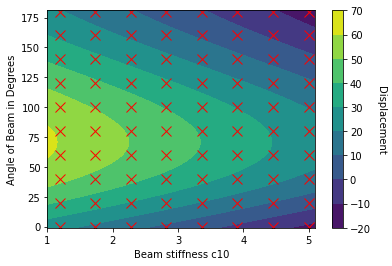

In [11]:
# Plot surrogate model surface:
d_pts, theta_pts = jnp.linspace(1, 5.1, 1000), jnp.linspace(-1, 181, 1000)
d_grid, theta_grid = jnp.meshgrid(theta_pts, d_pts)
x = jnp.vstack((theta_grid.flatten(), d_grid.flatten())).T
y_pts = surrogate.predict_mean(x)
y_grid = y_pts.reshape(d_pts.size,theta_pts.size)
train_dict = {"theta": x_train[:,1], "d": x_train[:,0]}
plot_gp_surface(d_grid, theta_grid, y_grid, train_dict)

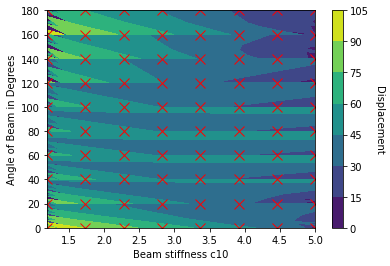

In [18]:
# Plot difference between training data and GP:
y_pred = surrogate.predict_mean(x_train)
plot_gp_surface(x_train[:,1], x_train[:,0], jnp.abs(y_pred-y_train), train_dict)

In [21]:
# Save Gaussian process model:
save_gp(surrogate, "partially_linear_kernel_gp")